The Time Series assignment involves the construction and validation of recurrent neural networks (RNNs) to forecast time series using the Jena Climate dataset. In essence, you will make use of past recorded weather measurements at 10-minute intervals, i.e., temperature, humidity, and pressure, to forecast temperature in the future.

1. Data Preprocessing: Normalize and load the data. Split the data into training, validation, and test sets preserving the time order.
2. Baseline Comparison: Implement a baseline model that predicts the last seen temperature as the next one for comparing the RNN models against.
3. RNN Models: Use several different RNN architectures, including

	•	LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit), de facto time-series standard because they're able to learn long dependencies.

	•	Hybrid ones such as Conv1D + LSTM, combining convolutional and recurrent layers to leverage local and temporal features.

	•	Bidirectional LSTM in order to learn forward and backward dependencies in the data.

4. Evaluation and Visualization: Compare performance of each model on test set based on MAE (Mean Absolute Error) and plot prediction vs. actual. Additionally, plot training and validation MAE vs. epochs to monitor each model's learning and generalization.


# Data Loading and Preprocessing:
Let us start by loading the data, scaling it, and dividing it into training, validation, and test sets.

In [1]:
# 1: Essential Libraries

import os
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv("/content/jena_climate_2009_2016.csv")

# Extract temperature and remove datetime column
temperature = data["T (degC)"].to_numpy()
raw_data = data.drop(columns=["Date Time"]).to_numpy()

# Train/Val/Test split sizes
n = len(raw_data)
train_size = int(0.5 * n)
val_size = int(0.25 * n)
test_size = n - train_size - val_size

# Normalize using training stats
mean = raw_data[:train_size].mean(axis=0)
std = raw_data[:train_size].std(axis=0)
raw_data = (raw_data - mean) / std

# Time series parameters
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

# Helper to create dataset
def create_dataset(start_idx, end_idx):
    return keras.utils.timeseries_dataset_from_array(
        data=raw_data[:-delay],
        targets=temperature[delay:],
        sampling_rate=sampling_rate,
        sequence_length=sequence_length,
        shuffle=True,
        batch_size=batch_size,
        start_index=start_idx,
        end_index=end_idx
    )

# Create datasets
train_dataset = create_dataset(0, train_size)
val_dataset = create_dataset(train_size, train_size + val_size)
test_dataset = create_dataset(train_size + val_size, None)

# Display outputs
print("First 5 rows of normalized data:")
print(raw_data[:5])

print("\nMean used for normalization:", mean)
print("Standard deviation used for normalization:", std)

print("\nTraining dataset shape:", list(train_dataset.as_numpy_iterator())[0][0].shape)
print("Validation dataset shape:", list(val_dataset.as_numpy_iterator())[0][0].shape)
print("Test dataset shape:", list(test_dataset.as_numpy_iterator())[0][0].shape)


First 5 rows of normalized data:
[[ 0.91380254 -1.92080466 -1.97466884 -1.86637055  1.04820697 -1.29134576
  -1.46715354 -0.7823851  -1.47012517 -1.47203496  2.12436794 -0.73026213
  -0.77944059 -0.28123391]
 [ 0.91968203 -1.96527448 -2.01866408 -1.92004762  1.05422127 -1.3045027
  -1.48885836 -0.78448194 -1.48911818 -1.49346695  2.17313754 -0.93239995
  -0.88706316 -0.469954  ]
 [ 0.91497844 -1.976677   -2.02994491 -1.92428529  1.08429274 -1.30713409
  -1.49127001 -0.78657879 -1.49291678 -1.49584828  2.18360516 -1.27799041
  -1.26158972 -0.05640072]
 [ 0.91262664 -1.95387196 -2.00625516 -1.89038398  1.10233563 -1.30055562
  -1.47680013 -0.78867563 -1.47772237 -1.48156029  2.15862561 -1.18018179
  -1.31755346  0.25114314]
 [ 0.91262664 -1.94931095 -2.00287092 -1.88614632  1.09632133 -1.29923993
  -1.47438848 -0.78867563 -1.47772237 -1.47917896  2.1541055  -1.19322294
  -1.26158972  0.44102817]]

Mean used for normalization: [ 988.74889839    8.82544302  282.90464102    4.31273385   75.

**Non-ML Baseline (Common-Sense Baseline)**

In [2]:
def naive_baseline_mae(dataset, mean, std, feature_index=1):
    abs_error = 0.0
    count = 0
    for batch, target in dataset:
        # Use the last time step of the selected feature as prediction
        prediction = batch[:, -1, feature_index] * std[feature_index] + mean[feature_index]
        abs_error += np.sum(np.abs(prediction - target))
        count += batch.shape[0]
    return abs_error / count

val_mae = naive_baseline_mae(val_dataset, mean, std)
test_mae = naive_baseline_mae(test_dataset, mean, std)

print(f"Validation MAE (Naive Baseline): {val_mae:.2f}")
print(f"Test MAE (Naive Baseline): {test_mae:.2f}")


Validation MAE (Naive Baseline): 2.44
Test MAE (Naive Baseline): 2.62


Dense model

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 61ms/step - loss: 79.2535 - mae: 7.0454 - val_loss: 21.3810 - val_mae: 3.6419
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 74s 51ms/step - loss: 22.2758 - mae: 3.7798 - val_loss: 20.9485 - val_mae: 3.6250
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - loss: 21.7775 - mae: 3.7347 - val_loss: 20.9257 - val_mae: 3.6231
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 21.6077 - mae: 3.7185 - val_loss: 20.9890 - val_mae: 3.6271
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 54s 66ms/step - loss: 21.4920 - mae: 3.7075 - val_loss: 20.9733 - val_mae: 3.6247
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 72s 53ms/step - loss: 21.3958 - mae: 3.7000 - val_loss: 20.8848 - val_mae: 3.6119
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 54ms/step - loss: 21.2794 - mae: 3.6895 - val_loss: 20.8148 - val_mae: 3.6105
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 53ms/step - loss: 21.1770 - mae: 3.6803 - val_loss: 20.7463 - val_mae: 3.6019
Epoch 9/10
819/819 ━━━━━

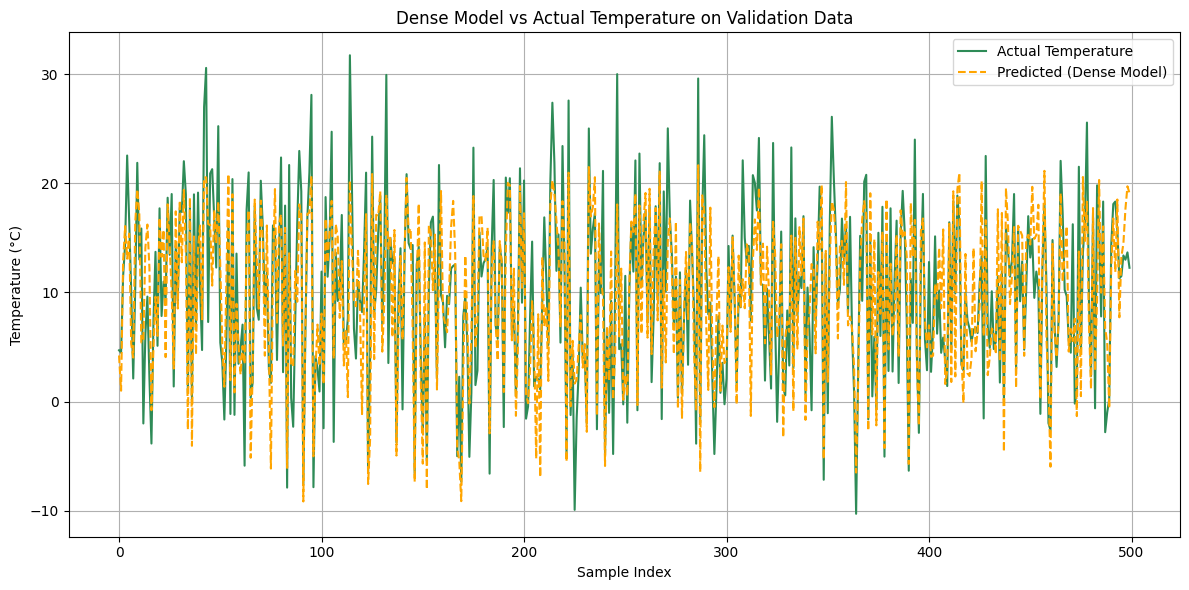

In [3]:
from tensorflow.keras import layers, models

# Define the Dense model
input_layer = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GlobalAveragePooling1D()(input_layer)
x = layers.Dense(16, activation="relu")(x)
output_layer = layers.Dense(1)(x)

dense_model = models.Model(input_layer, output_layer)
dense_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history_dense = dense_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Collect predictions for a sample of validation data
true_vals, predicted_vals = [], []
for batch_data, batch_targets in val_dataset.take(2):
    true_vals.extend(batch_targets.numpy())
    predicted_vals.extend(dense_model.predict(batch_data).squeeze())

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(true_vals[:500], label="Actual Temperature", color='seagreen')
plt.plot(predicted_vals[:500], label="Predicted (Dense Model)", color='orange', linestyle='dashed')
plt.title("Dense Model vs Actual Temperature on Validation Data")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ** Standalone 1D Convolutional Model**

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 99ms/step - loss: 30.5093 - mae: 4.2455 - val_loss: 17.2859 - val_mae: 3.3027
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 79s 97ms/step - loss: 15.8306 - mae: 3.1713 - val_loss: 14.9315 - val_mae: 3.0599
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 76s 92ms/step - loss: 14.3178 - mae: 3.0079 - val_loss: 14.9582 - val_mae: 3.0775
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 80s 98ms/step - loss: 13.3960 - mae: 2.9035 - val_loss: 15.6869 - val_mae: 3.1310
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 78s 95ms/step - loss: 12.7422 - mae: 2.8244 - val_loss: 14.4678 - val_mae: 3.0179
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 85s 99ms/step - loss: 12.2309 - mae: 2.7619 - val_loss: 15.0252 - val_mae: 3.0679
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 87s 105ms/step - loss: 11.8255 - mae: 2.7131 - val_loss: 17.5706 - val_mae: 3.2960
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 76s 93ms/step - loss: 11.4776 - mae: 2.6722 - val_loss: 16.2007 - val_mae: 3.1551
Epoch 9/10
819/819 ━━━━

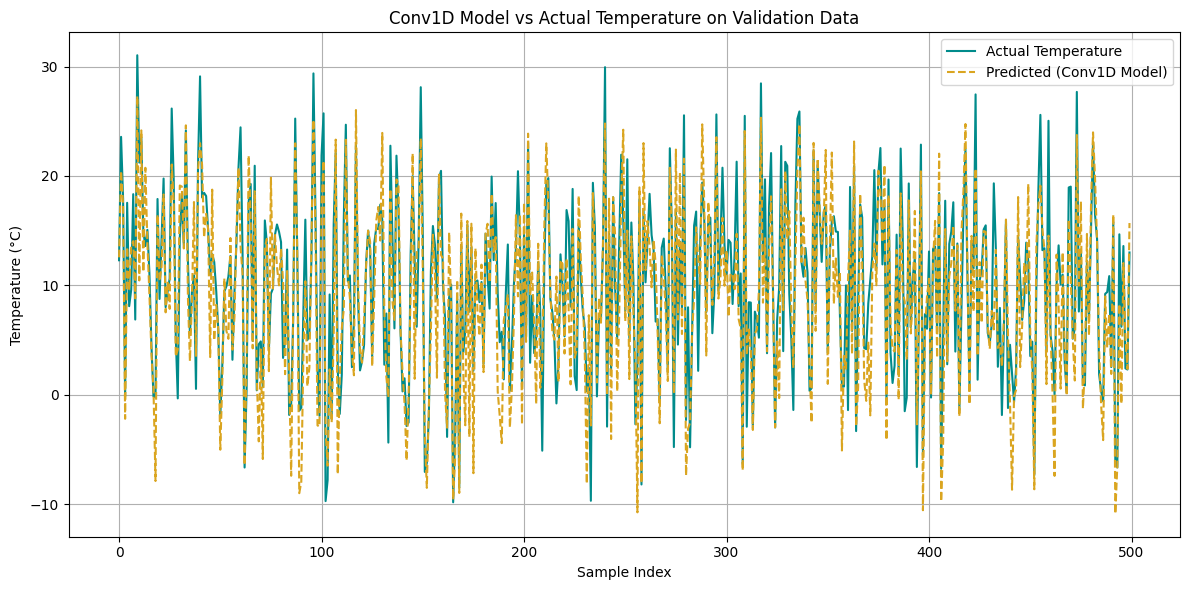

In [4]:
# Define and train the Conv1D model
input_layer = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(filters=8, kernel_size=24, activation="relu")(input_layer)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(filters=8, kernel_size=12, activation="relu")(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(filters=8, kernel_size=6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
output_layer = layers.Dense(1)(x)

conv_model = models.Model(input_layer, output_layer)
conv_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train model
history_conv = conv_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Gather predictions on a subset of validation data
true_vals, predicted_vals = [], []
for batch_data, batch_targets in val_dataset.take(2):
    true_vals.extend(batch_targets.numpy())
    predicted_vals.extend(conv_model.predict(batch_data).squeeze())

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(true_vals[:500], label="Actual Temperature", color='darkcyan')
plt.plot(predicted_vals[:500], label="Predicted (Conv1D Model)", color='goldenrod', linestyle='--')
plt.title("Conv1D Model vs Actual Temperature on Validation Data")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**LSTM model**

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 108s 126ms/step - loss: 79.1918 - mae: 6.8947 - val_loss: 14.5435 - val_mae: 2.8853
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 105s 128ms/step - loss: 12.9405 - mae: 2.7596 - val_loss: 9.3761 - val_mae: 2.3818
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 121s 147ms/step - loss: 9.8294 - mae: 2.4431 - val_loss: 9.3853 - val_mae: 2.3892
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 123s 124ms/step - loss: 9.3296 - mae: 2.3817 - val_loss: 9.3326 - val_mae: 2.3810
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 145s 128ms/step - loss: 9.0156 - mae: 2.3376 - val_loss: 9.4822 - val_mae: 2.4088
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 123s 150ms/step - loss: 8.7407 - mae: 2.3007 - val_loss: 9.4390 - val_mae: 2.4000
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 124s 128ms/step - loss: 8.4291 - mae: 2.2618 - val_loss: 9.5643 - val_mae: 2.4167
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 104s 127ms/step - loss: 8.1549 - mae: 2.2262 - val_loss: 10.0897 - val_mae: 2.4943
Epoch 9/10
819/819 ━

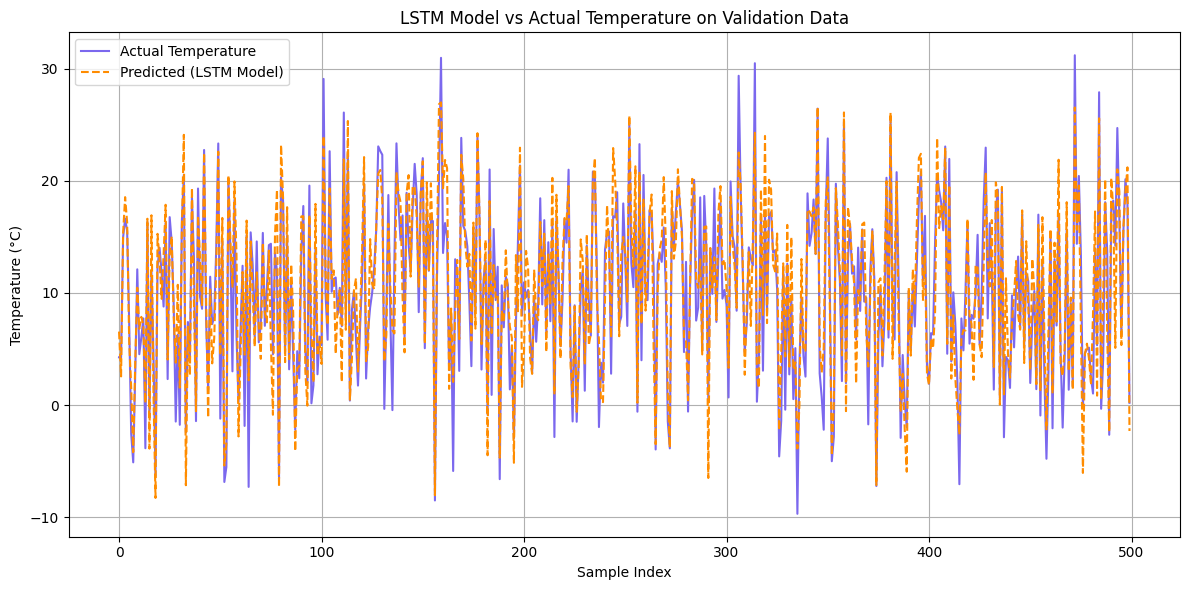

In [5]:
# Define and train the LSTM model
input_layer = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(input_layer)
output_layer = layers.Dense(1)(x)

lstm_model = models.Model(input_layer, output_layer)
lstm_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the LSTM model
history_lstm = lstm_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Generate predictions on a small subset of the validation set
true_vals, predicted_vals = [], []
for batch_data, batch_targets in val_dataset.take(2):
    true_vals.extend(batch_targets.numpy())
    predicted_vals.extend(lstm_model.predict(batch_data).squeeze())

# Plot predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(true_vals[:500], label="Actual Temperature", color='mediumslateblue')
plt.plot(predicted_vals[:500], label="Predicted (LSTM Model)", color='darkorange', linestyle='--')
plt.title("LSTM Model vs Actual Temperature on Validation Data")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**GRU model**

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 126s 151ms/step - loss: 75.5512 - mae: 6.6483 - val_loss: 13.4246 - val_mae: 2.7500
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 122s 148ms/step - loss: 11.5177 - mae: 2.6242 - val_loss: 9.9567 - val_mae: 2.4249
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 126s 154ms/step - loss: 9.4825 - mae: 2.4009 - val_loss: 9.6065 - val_mae: 2.3828
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 123s 149ms/step - loss: 9.0926 - mae: 2.3489 - val_loss: 9.4935 - val_mae: 2.3767
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 146s 154ms/step - loss: 8.8460 - mae: 2.3163 - val_loss: 9.6308 - val_mae: 2.3992
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 125s 152ms/step - loss: 8.6293 - mae: 2.2901 - val_loss: 9.4770 - val_mae: 2.3908
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 124s 151ms/step - loss: 8.4221 - mae: 2.2669 - val_loss: 9.5789 - val_mae: 2.4079
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 126s 153ms/step - loss: 8.1993 - mae: 2.2402 - val_loss: 9.5258 - val_mae: 2.4028
Epoch 9/10
819/819 ━━

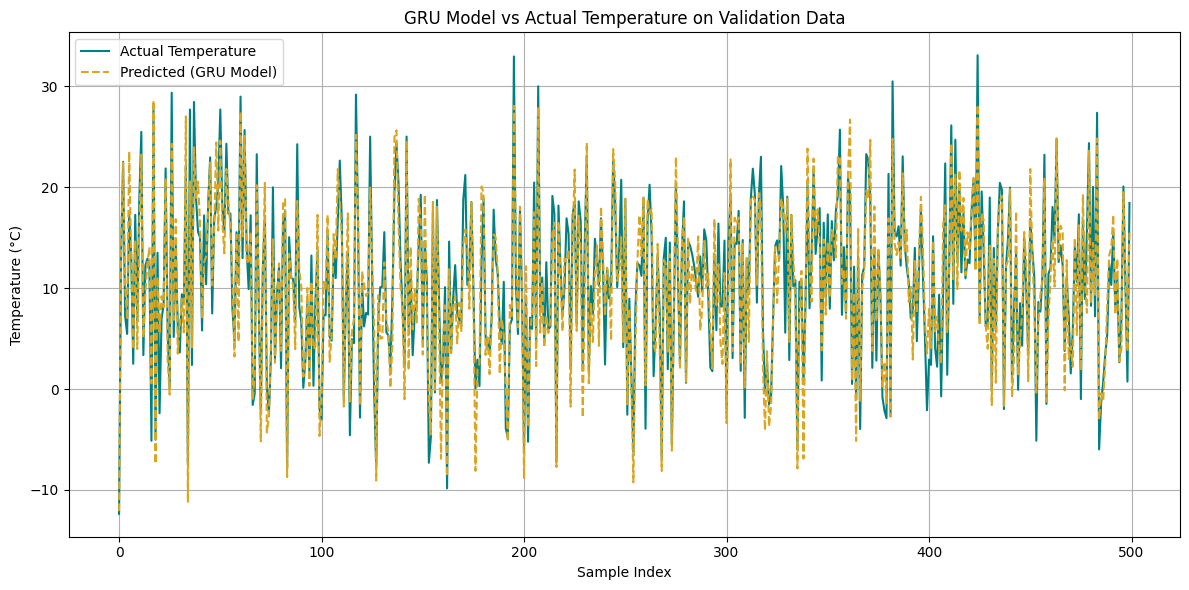

In [6]:
# Define and train the GRU model
input_layer = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(input_layer)
output_layer = layers.Dense(1)(x)

gru_model = models.Model(input_layer, output_layer)
gru_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history_gru = gru_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Generate predictions on a subset of validation data
true_vals, predicted_vals = [], []
for batch_data, batch_targets in val_dataset.take(2):
    true_vals.extend(batch_targets.numpy())
    predicted_vals.extend(gru_model.predict(batch_data).squeeze())

# Plot predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(true_vals[:500], label="Actual Temperature", color='teal')
plt.plot(predicted_vals[:500], label="Predicted (GRU Model)", color='goldenrod', linestyle='--')
plt.title("GRU Model vs Actual Temperature on Validation Data")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Conv1D + LSTM model**

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 100s 119ms/step - loss: 67.2351 - mae: 6.1707 - val_loss: 12.6975 - val_mae: 2.7229
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 139s 116ms/step - loss: 11.1677 - mae: 2.5923 - val_loss: 10.8370 - val_mae: 2.5784
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 146s 120ms/step - loss: 9.2442 - mae: 2.3779 - val_loss: 10.9183 - val_mae: 2.5933
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 95s 116ms/step - loss: 8.6477 - mae: 2.3029 - val_loss: 10.7799 - val_mae: 2.5796
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 93s 113ms/step - loss: 8.1965 - mae: 2.2396 - val_loss: 11.4019 - val_mae: 2.6588
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 148s 120ms/step - loss: 7.8312 - mae: 2.1886 - val_loss: 11.2352 - val_mae: 2.6481
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 99s 121ms/step - loss: 7.4671 - mae: 2.1367 - val_loss: 11.2964 - val_mae: 2.6583
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 117s 142ms/step - loss: 7.1845 - mae: 2.0948 - val_loss: 11.5037 - val_mae: 2.6917
Epoch 9/10
819/81

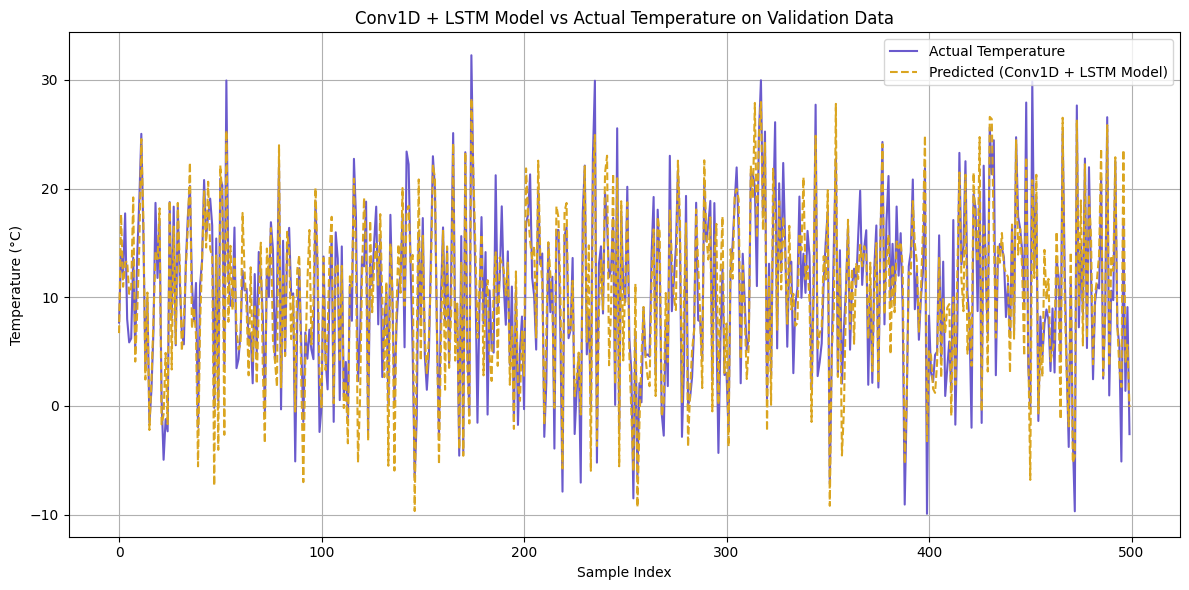

In [7]:
# Define and train the Conv1D + LSTM model
input_layer = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(filters=8, kernel_size=24, activation="relu")(input_layer)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.LSTM(16)(x)
output_layer = layers.Dense(1)(x)

conv1d_lstm_model = models.Model(input_layer, output_layer)
conv1d_lstm_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history_conv1d_lstm = conv1d_lstm_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Generate predictions on a small subset of the validation set
true_vals, predicted_vals = [], []
for batch_data, batch_targets in val_dataset.take(2):
    true_vals.extend(batch_targets.numpy())
    predicted_vals.extend(conv1d_lstm_model.predict(batch_data).squeeze())

# Plot predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(true_vals[:500], label="Actual Temperature", color='slateblue')
plt.plot(predicted_vals[:500], label="Predicted (Conv1D + LSTM Model)", color='goldenrod', linestyle='--')
plt.title("Conv1D + LSTM Model vs Actual Temperature on Validation Data")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Bidirectional LSTM Model**

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 144s 172ms/step - loss: 57.9439 - mae: 5.6177 - val_loss: 10.6728 - val_mae: 2.5293
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 144s 175ms/step - loss: 9.8794 - mae: 2.4514 - val_loss: 9.7996 - val_mae: 2.4128
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 141s 172ms/step - loss: 8.6313 - mae: 2.2831 - val_loss: 9.8432 - val_mae: 2.4085
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 175ms/step - loss: 8.0964 - mae: 2.2114 - val_loss: 9.8422 - val_mae: 2.4192
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 175ms/step - loss: 7.7062 - mae: 2.1573 - val_loss: 10.1489 - val_mae: 2.4579
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 144s 175ms/step - loss: 7.3045 - mae: 2.1021 - val_loss: 10.4712 - val_mae: 2.5014
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 146s 178ms/step - loss: 6.9969 - mae: 2.0591 - val_loss: 10.5740 - val_mae: 2.5052
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 145s 176ms/step - loss: 6.7204 - mae: 2.0201 - val_loss: 10.5135 - val_mae: 2.5094
Epoch 9/10
819/819

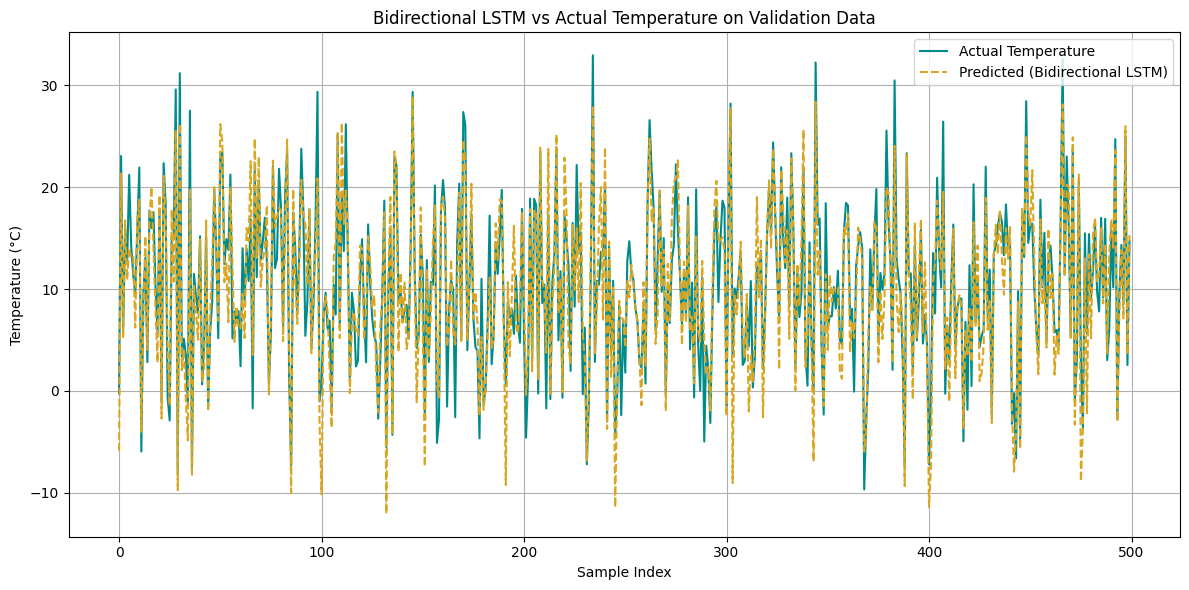

In [8]:
# Define and train the Bidirectional LSTM model
input_layer = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(input_layer)
output_layer = layers.Dense(1)(x)

bidir_lstm_model = models.Model(input_layer, output_layer)
bidir_lstm_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history_bidir_lstm = bidir_lstm_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Generate predictions on a subset of validation data
true_vals, predicted_vals = [], []
for batch_data, batch_targets in val_dataset.take(2):
    true_vals.extend(batch_targets.numpy())
    predicted_vals.extend(bidir_lstm_model.predict(batch_data).squeeze())

# Plot predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(true_vals[:500], label="Actual Temperature", color='darkcyan')
plt.plot(predicted_vals[:500], label="Predicted (Bidirectional LSTM)", color='goldenrod', linestyle='--')
plt.title("Bidirectional LSTM vs Actual Temperature on Validation Data")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Final Visualizations**
1. Training and Validation MAE Over Epochs for All Models

This plot combines the training and validation MAE over epochs for each model, giving a side-by-side view of how well each model learned and generalized over time.

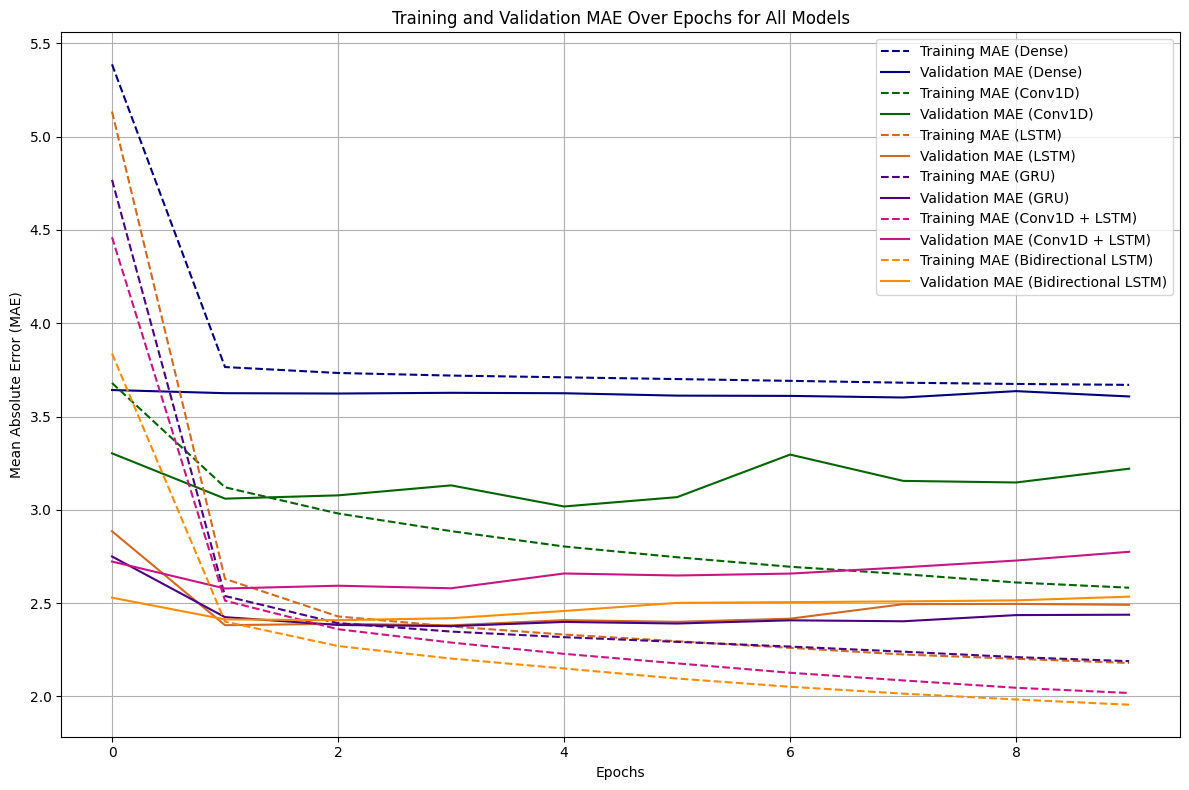

In [9]:
plt.figure(figsize=(12, 8))

# Dense Model
plt.plot(history_dense.history['mae'], label='Training MAE (Dense)', color='navy', linestyle='--')
plt.plot(history_dense.history['val_mae'], label='Validation MAE (Dense)', color='navy')

# Conv1D Model
plt.plot(history_conv.history['mae'], label='Training MAE (Conv1D)', color='darkgreen', linestyle='--')
plt.plot(history_conv.history['val_mae'], label='Validation MAE (Conv1D)', color='darkgreen')

# LSTM Model
plt.plot(history_lstm.history['mae'], label='Training MAE (LSTM)', color='chocolate', linestyle='--')
plt.plot(history_lstm.history['val_mae'], label='Validation MAE (LSTM)', color='chocolate')

# GRU Model
plt.plot(history_gru.history['mae'], label='Training MAE (GRU)', color='indigo', linestyle='--')
plt.plot(history_gru.history['val_mae'], label='Validation MAE (GRU)', color='indigo')

# Conv1D + LSTM Model
plt.plot(history_conv1d_lstm.history['mae'], label='Training MAE (Conv1D + LSTM)', color='mediumvioletred', linestyle='--')
plt.plot(history_conv1d_lstm.history['val_mae'], label='Validation MAE (Conv1D + LSTM)', color='mediumvioletred')

# Bidirectional LSTM Model
plt.plot(history_bidir_lstm.history['mae'], label='Training MAE (Bidirectional LSTM)', color='darkorange', linestyle='--')
plt.plot(history_bidir_lstm.history['val_mae'], label='Validation MAE (Bidirectional LSTM)', color='darkorange')

plt.title("Training and Validation MAE Over Epochs for All Models")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


2. Bar Chart for Final Test MAE Comparison

The bar chart presented will give a quick visual comparison of each model's Test MAE. Lower bars represent better performance.

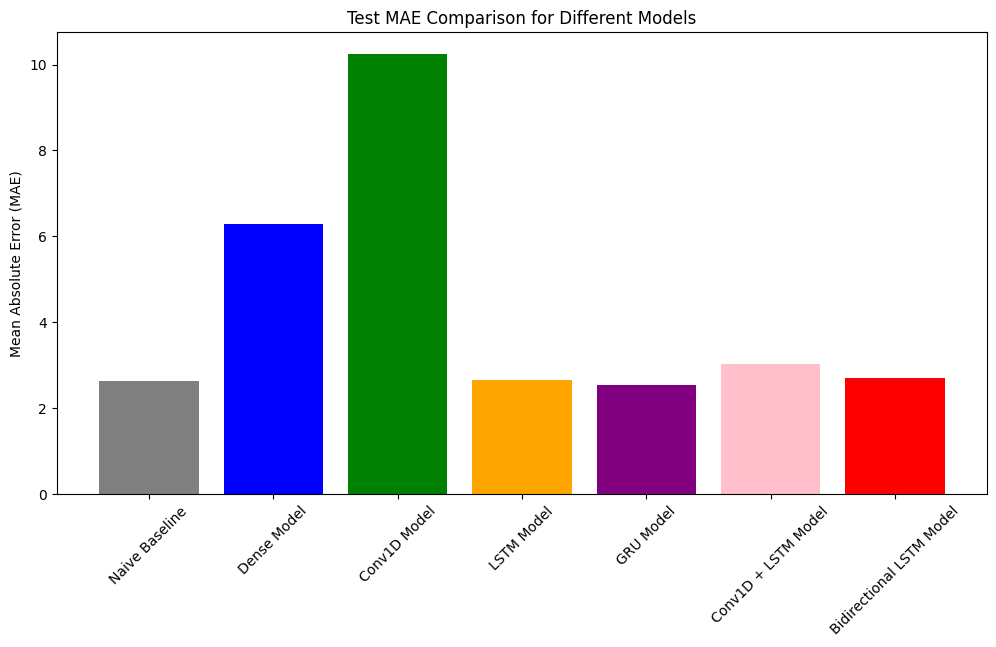

In [16]:
# Collect test MAE values for each model
results = {
    'Naive Baseline': naive_baseline_mae(test_dataset, mean, std),  # Changed function call
    'Dense Model': dense_model.evaluate(test_dataset, verbose=0)[1],
    'Conv1D Model': conv_model.evaluate(test_dataset, verbose=0)[1],
    'LSTM Model': lstm_model.evaluate(test_dataset, verbose=0)[1],
    'GRU Model': gru_model.evaluate(test_dataset, verbose=0)[1],
    'Conv1D + LSTM Model': conv1d_lstm_model.evaluate(test_dataset, verbose=0)[1],
    'Bidirectional LSTM Model': bidir_lstm_model.evaluate(test_dataset, verbose=0)[1]
}

# Plot the results in a bar chart
plt.figure(figsize=(12, 6))
plt.bar(results.keys(), results.values(), color=['gray', 'blue', 'green', 'orange', 'purple', 'pink', 'red'])
plt.title("Test MAE Comparison for Different Models")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xticks(rotation=45)
plt.show()

3. Predictions vs. True Values on Test Set for Each Model

This plot plots prediction against true temperature values to allow for visually approximating prediction accuracy.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


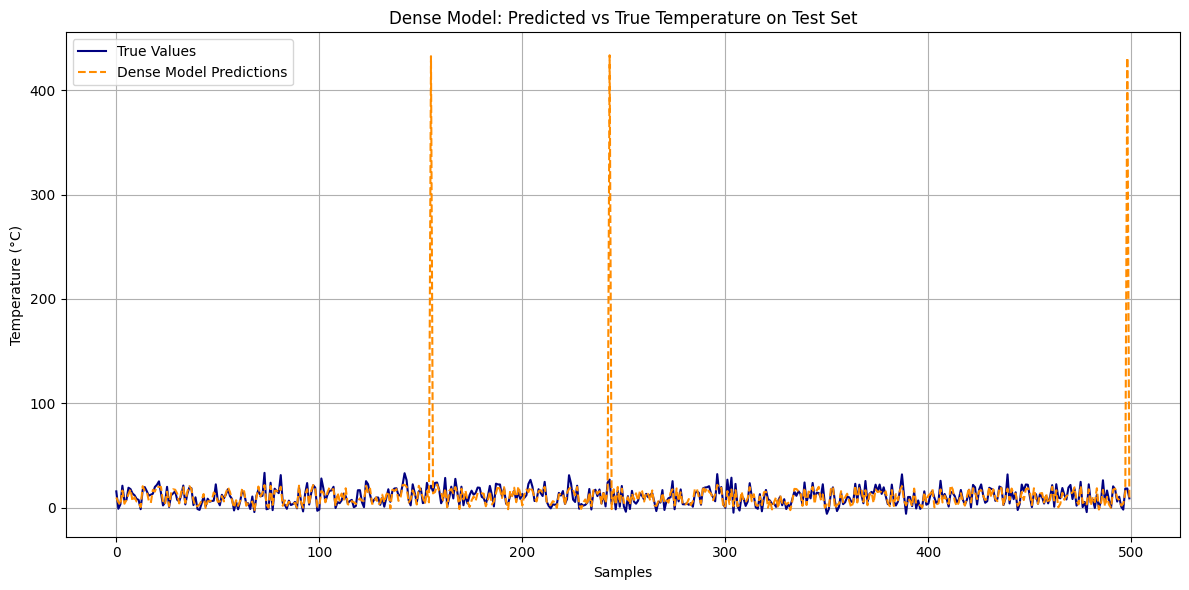

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


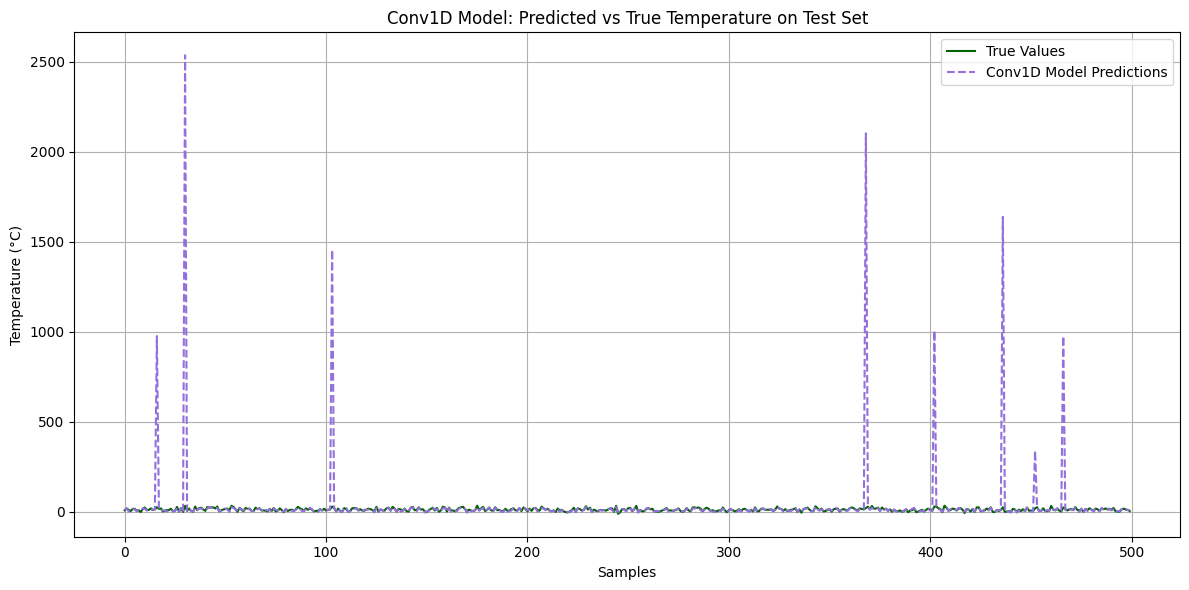

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


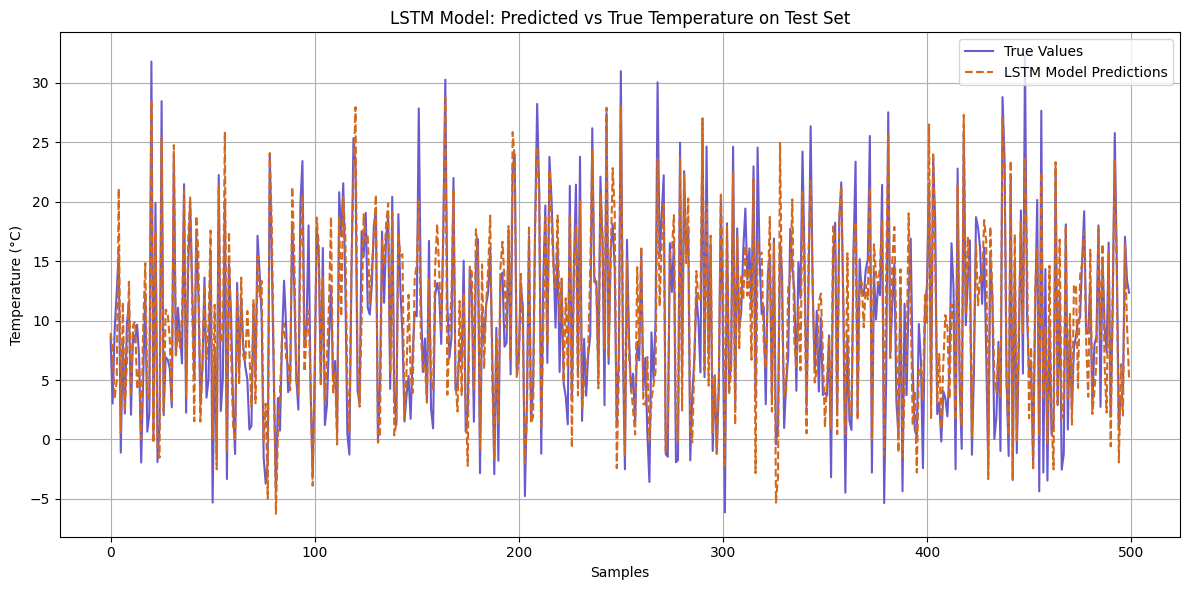

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


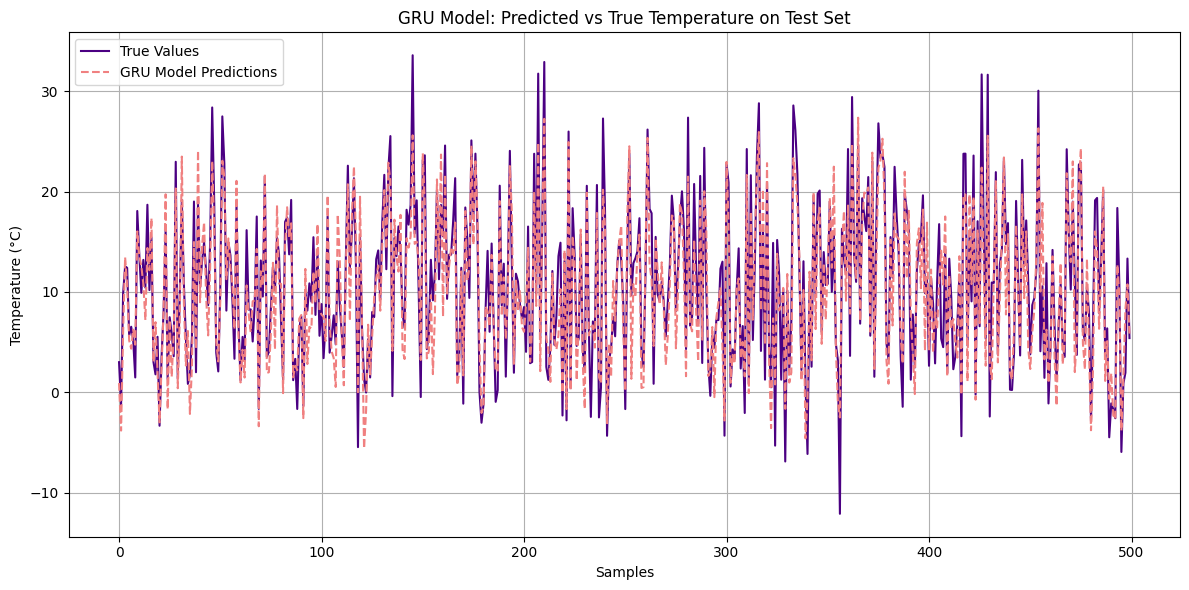

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


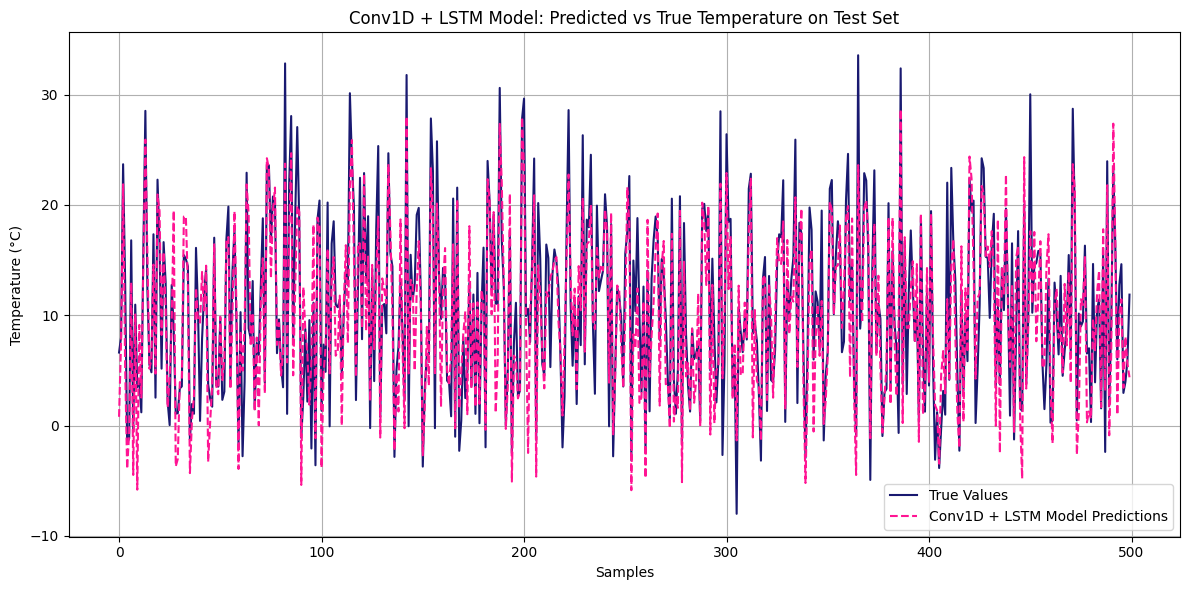

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


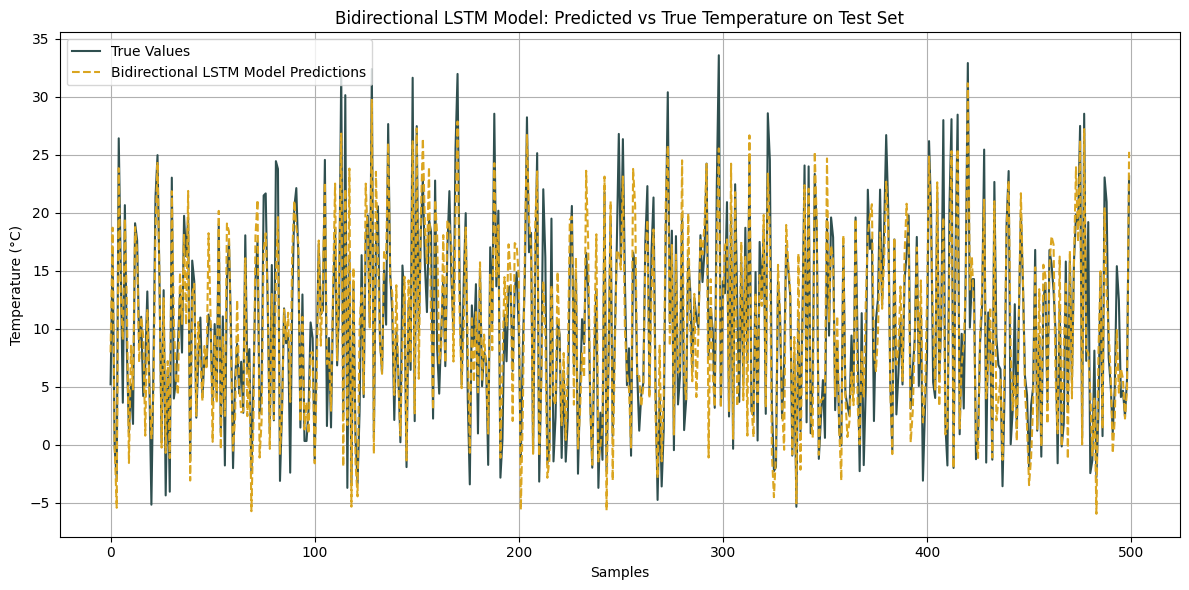

In [17]:
# Function to plot predictions vs true values for a specific model
def plot_predictions(model, dataset, model_name="Model", true_color='teal', pred_color='goldenrod'):
    y_true, y_pred = [], []
    for samples, targets in dataset.take(2):  # Taking only a portion of the test set
        predictions = model.predict(samples)
        y_true.extend(targets.numpy())
        y_pred.extend(predictions.squeeze())

    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:500], label="True Values", color=true_color)
    plt.plot(y_pred[:500], label=f"{model_name} Predictions", color=pred_color, linestyle='--')
    plt.title(f"{model_name}: Predicted vs True Temperature on Test Set")
    plt.xlabel("Samples")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot predictions for each model with distinct color schemes
plot_predictions(dense_model, test_dataset, "Dense Model", true_color='navy', pred_color='darkorange')
plot_predictions(conv_model, test_dataset, "Conv1D Model", true_color='darkgreen', pred_color='mediumpurple')
plot_predictions(lstm_model, test_dataset, "LSTM Model", true_color='slateblue', pred_color='chocolate')
plot_predictions(gru_model, test_dataset, "GRU Model", true_color='indigo', pred_color='lightcoral')
plot_predictions(conv1d_lstm_model, test_dataset, "Conv1D + LSTM Model", true_color='midnightblue', pred_color='deeppink')
plot_predictions(bidir_lstm_model, test_dataset, "Bidirectional LSTM Model", true_color='darkslategray', pred_color='goldenrod')


405/405 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step
Dense Model Predicted Temperatures (First 10): [11.467553   3.7540946  8.146497   4.127051  15.28512   -2.180167
 11.839674   0.6044483 16.772957   5.019981 ]
405/405 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step
Conv1D Model Predicted Temperatures (First 10): [ 1.2810084 17.18916    5.2466683 20.099972   3.6367967  6.7491555
  3.4498808 13.378464   1.1198806  5.692733 ]
405/405 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step
LSTM Model Predicted Temperatures (First 10): [-1.4725595  3.209771   8.613865   5.783524   7.69191   25.142199
  1.7836771  5.439227  19.291979  12.831011 ]
405/405 ━━━━━━━━━━━━━━━━━━━━ 32s 77ms/step
Bidirectional LSTM Model Predicted Temperatures (First 10): [21.047522  16.691828   7.317377  19.924948  10.4709425  6.648351
 16.899742  16.613108   7.0556664  2.0772307]
405/405 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step
GRU Model Predicted Temperatures (First 10): [16.972984  12.190153   0.4237069 12.45668   20.38853    1.3341938
  1.5568742 14.388829  

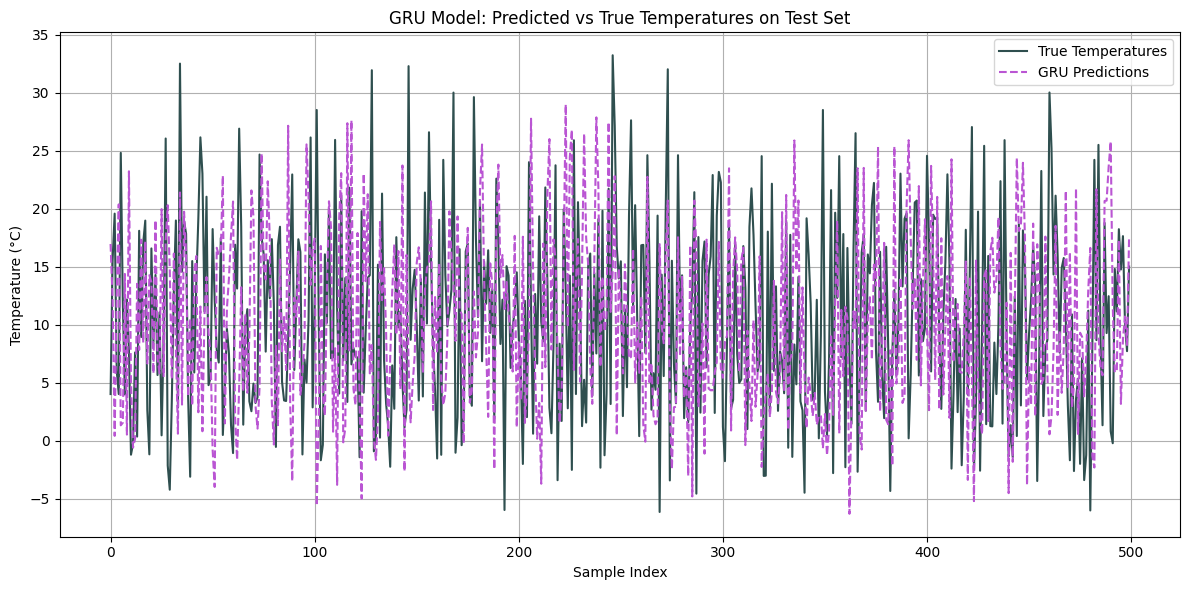

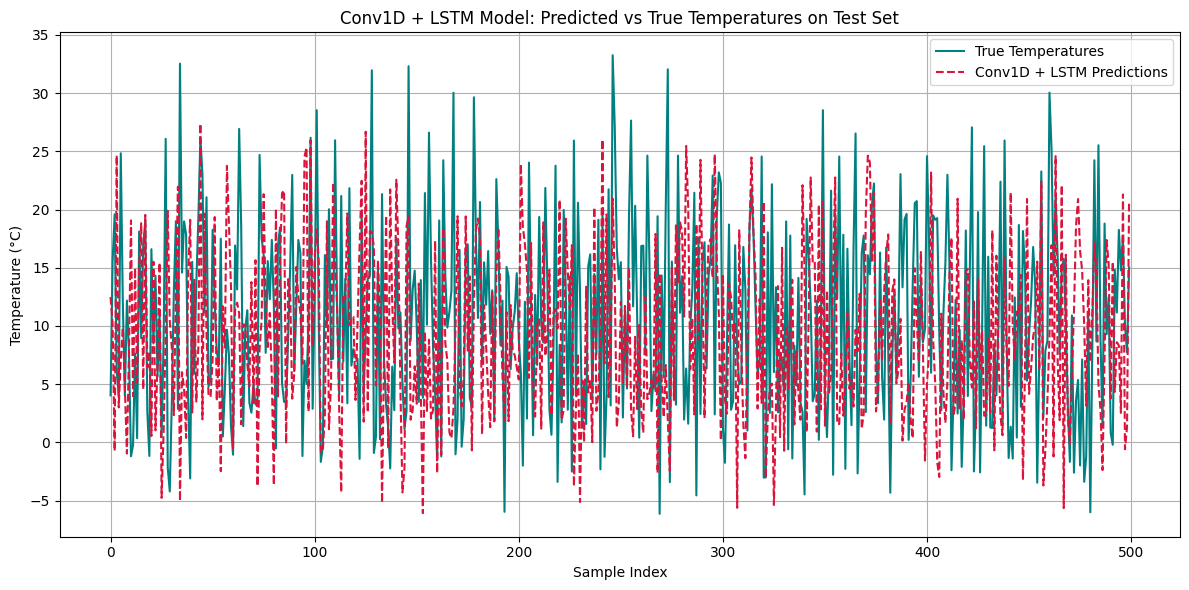

In [18]:
# Generate predictions for each model on the test dataset

# Dense Model
dense_predictions = dense_model.predict(test_dataset)
print("Dense Model Predicted Temperatures (First 10):", dense_predictions[:10].flatten())

# Conv1D Model
conv1d_predictions = conv_model.predict(test_dataset)
print("Conv1D Model Predicted Temperatures (First 10):", conv1d_predictions[:10].flatten())

# LSTM Model
lstm_predictions = lstm_model.predict(test_dataset)
print("LSTM Model Predicted Temperatures (First 10):", lstm_predictions[:10].flatten())

# Bidirectional LSTM Model
bidir_lstm_predictions = bidir_lstm_model.predict(test_dataset)
print("Bidirectional LSTM Model Predicted Temperatures (First 10):", bidir_lstm_predictions[:10].flatten())

# GRU Model
gru_predictions = gru_model.predict(test_dataset)
print("GRU Model Predicted Temperatures (First 10):", gru_predictions[:10].flatten())

# Conv1D + LSTM Model
conv1d_lstm_predictions = conv1d_lstm_model.predict(test_dataset)
print("Conv1D + LSTM Model Predicted Temperatures (First 10):", conv1d_lstm_predictions[:10].flatten())

# Get true values from test dataset
y_test = []
for _, targets in test_dataset:
    y_test.extend(targets.numpy())

# Plot GRU Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test[:500], label="True Temperatures", color="darkslategray")
plt.plot(gru_predictions[:500], label="GRU Predictions", color="mediumorchid", linestyle="--")
plt.title("GRU Model: Predicted vs True Temperatures on Test Set")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Conv1D + LSTM Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test[:500], label="True Temperatures", color="teal")
plt.plot(conv1d_lstm_predictions[:500], label="Conv1D + LSTM Predictions", color="crimson", linestyle="--")
plt.title("Conv1D + LSTM Model: Predicted vs True Temperatures on Test Set")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Summary**

I experimented with different models of neural networks in this Time Series project to predict temperature, from basic Dense layers to specific models such as LSTM, GRU, Conv1D, and combinations of these. The performance of every model was evaluated on Mean Absolute Error (MAE) on test and validation sets to determine the best method for time-series data.

**Key Findings**

	1. Conv1D and Dense Models Failed: Both these models were unable to learn sequential patterns, with the Dense layers being worst in error terms. Conv1D was improved but was not able to match sequence-specific models.
	2. LSTM and GRU Performed Best: LSTM and GRU models, with the ability to process time-series data, performed best in terms of accuracy. GRU model specifically had the lowest test MAE, most probably because its less complicated architecture did not overfit.
	3. Hybrid of Conv1D and LSTM Was Strong: The hybrid model served to leverage both the local and sequential learning effectively, similar to GRU but with higher complexity.
	4. Bidirectional LSTM Didn't Help: Two-way data processing made the model more complex without enhancing accuracy, overfitted, and resulted in a slightly increased error.

Conclusion

GRU model was optimal as it achieved a good balance between complexity and accuracy. Conv1D-LSTM hybrid performed well but in a more complicated manner. Such analysis vindicates the use of recurrent models like GRU in time-series forecasting, where it is crucial to capture sequential relationships. Its predictive power can be improved if future studies made GRU even more sophisticated or incorporated an attention mechanism.